### Imports

In [36]:
import modin.pandas as md
import statsmodels as sm
import os
from tabulate import tabulate
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
import sys
sys.path.append('../library')

import itertools

from midStats import *
from core import *
from plotting import *

colorPalette = loadPalette()

### Load Data

In [37]:
dataFiles = [f for f in os.listdir('../data/') if 'movieDetails' in f]
dfs = [md.read_csv(os.path.join('../data/', f)) for f in dataFiles]
df = md.concat(dfs, ignore_index=True)
df.drop_duplicates(inplace=True, keep='last')

Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.


### Global Vars

In [4]:
colsOfInterest = ['runtime', 'revenue', 'budget']
plotWidth = 600
plotHeight = 600
saveImagePath = '../assets/savedImages/boxOfficeAndRuntime'

if not os.path.exists(saveImagePath):
    os.makedirs(saveImagePath)

### Remove Outliers & Missing Data

In [5]:
df = df[df['budget'] > 0]
df = df[df['revenue'] > 0]
df = df[df['runtime'] > 0]

In [6]:
numCols = df.select_dtypes(include = ['number']).columns

for col in colsOfInterest:
    df[col] = dropNumericalOutliers(x = df[col], low = .01, high = .99)

df.dropna(subset=colsOfInterest, how='any', inplace=True)

### Describe Data

In [7]:
df[colsOfInterest].describe()

,runtime,revenue,budget
count,7449.000000,7.449000e+03,7.449000e+03
mean,107.723856,5.236473e+07,2.109420e+07
std,19.380258,9.314126e+07,2.792187e+07
min,72.000000,1.361000e+03,3.000000e+03
25%,94.000000,3.000000e+06,3.000000e+06
50%,104.000000,1.471179e+07,1.000000e+07
75%,118.000000,5.549556e+07,2.700000e+07
max,181.000000,7.098275e+08,1.750000e+08


#### Show Distributions

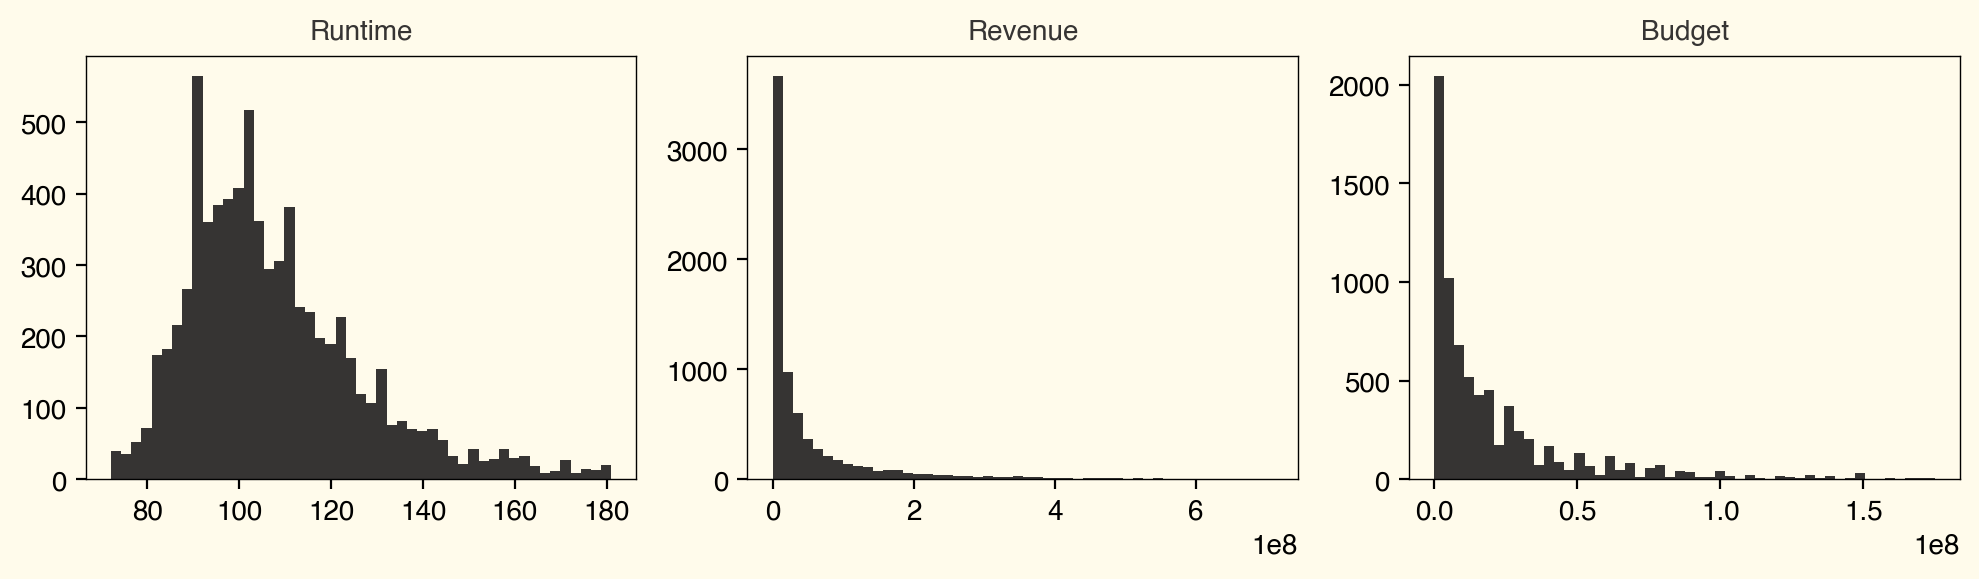

In [11]:
plt.style.use("../assets/plot_styles.mplstyle")

fig, axes = plt.subplots(1, len(colsOfInterest), figsize=(10,3))

# Iterate over the columns of interest and add histograms to subplots
for i, col in enumerate(colsOfInterest):
    # Check the range of the data
    min_val = df[col].min()
    max_val = df[col].max()
    
    # Calculate bin size
    bin_size = (max_val - min_val) / 50  # Example: 20 bins
    
    # Plot histogram
    axes[i].hist(df[col], bins=int((max_val - min_val) / bin_size))
    axes[i].set_title(f"{titleify(col)}")

# Adjust layout
plt.tight_layout()

# Save image
imageFilePath = os.path.join(saveImagePath, 'distributions.png')
plt.savefig(imageFilePath, dpi=300)

# Show the figure
plt.show()


#### Basic linear modelling

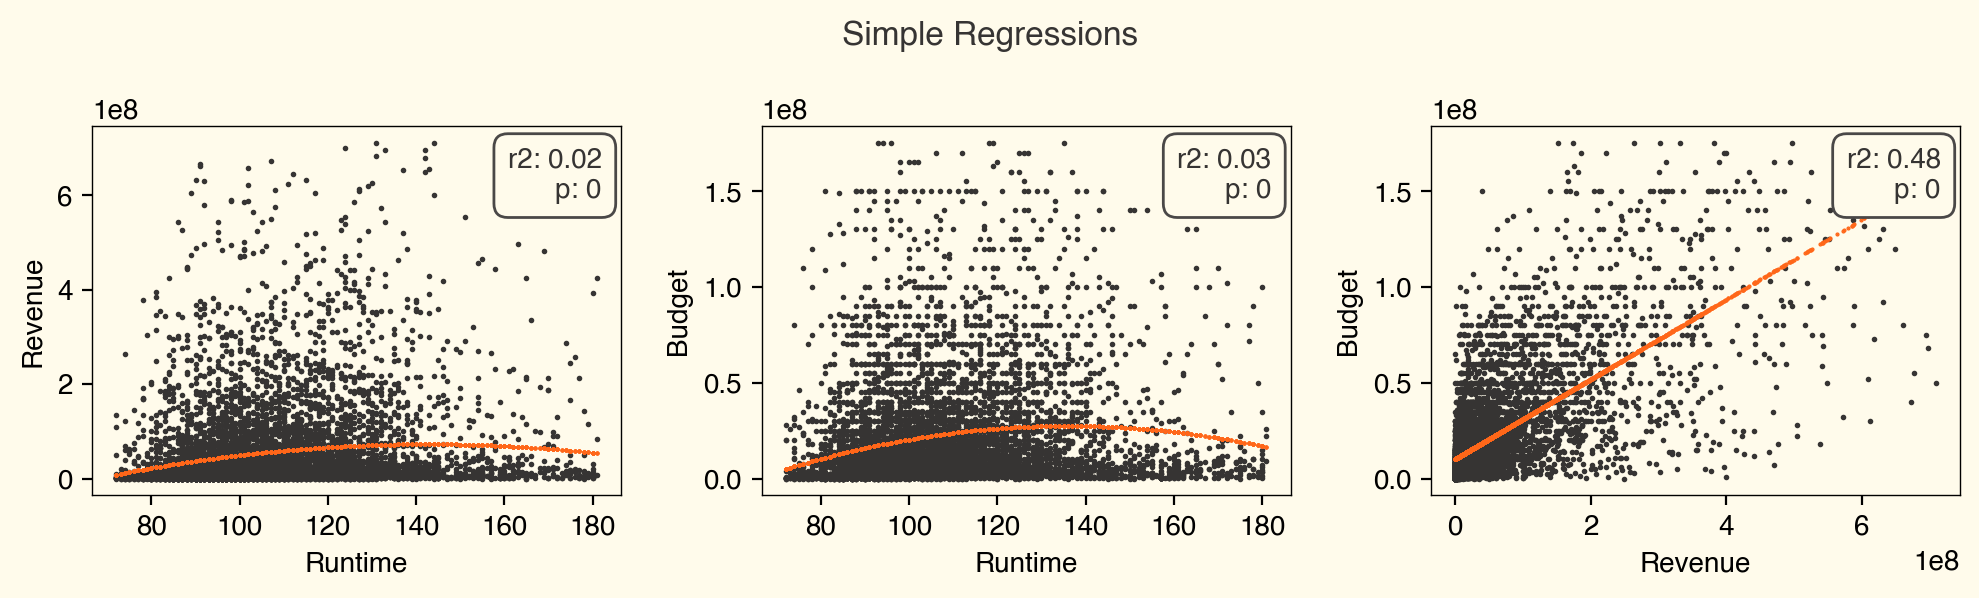

In [10]:
combos = list(itertools.combinations(colsOfInterest, 2))

fig, axes = plt.subplots(1, len(colsOfInterest), figsize=(10,3))
for i, combo in enumerate(combos):
    xVar = combo[0]
    yVar = combo[1]
    
    model = linearModelGeneral(np.array(df[xVar]), np.array(df[yVar]), [1,2])

    axes[i].scatter(df[xVar], df[yVar], s = 1)
    axes[i].scatter(model['X'], model['ypred'], marker='.', s=1, c=colorPalette['annotation'])
    
    axes[i].set_xlabel(titleify(xVar))
    axes[i].set_ylabel(titleify(yVar))

    annotation_text = f"r2: {round(model['r2'], 2)}\np: {round(model['p'])}"
    axes[i].annotate(annotation_text, xy=(.99, .98), xycoords='axes fraction', fontsize=10,
                    xytext=(-5, -5), textcoords='offset points',
                    ha='right', va='top',
                    bbox=dict(boxstyle='round,pad=0.5', edgecolor=colorPalette['grey_light'], facecolor=colorPalette['canvas']))


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Set title
fig.suptitle('Simple Regressions', fontsize=12)

imageFilePath = os.path.join(saveImagePath, 'simpleRegressions.png')
plt.savefig(imageFilePath, dpi=300)

# Show the figure
plt.show()

### How has runtime been changing over time?

In [12]:
df.head()

,Unnamed: 0,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,origin_country,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
1,1,False,/ke8MuTHVveodT0YQxV1TcTh4BXd.jpg,NaN,24900000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 878, 'na...",NaN,10001,tt0096486,"['AU', 'US']",...,1988-12-15,5000000.0,91.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,E=mc²,Young Einstein,False,5.100,145
3,3,False,/8HJnWvD85rxr0PC65YbWckjPvhM.jpg,NaN,68000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,10003,tt0120053,['US'],...,1997-04-03,118100000.0,116.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Never reveal your name. Never turn your back. ...,The Saint,False,6.108,1090
7,7,False,/cYeGgYKWhqfDZxnXZKWqJSjqg3.jpg,"{'id': 296872, 'name': 'See No Evil Collection...",8000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",NaN,10007,tt0437179,"['AU', 'US']",...,2006-05-19,18700000.0,84.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Evil Gets Raw,See No Evil,False,5.446,622
8,8,False,/wTcPEs307cPVYQ6lPXSjQEG416R.jpg,NaN,14000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",NaN,10008,tt0429573,"['US', 'GB', 'CA', 'RO']",...,2005-05-05,29612137.0,83.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Possession Knows No Bounds,An American Haunting,False,5.600,475
9,9,False,/nMKfeFtE9bML6yjdcymrt5vtaNz.jpg,"{'id': 96472, 'name': 'Brother Bear Collection...",128000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://movies.disney.com/brother-bear,10009,tt0328880,['US'],...,2003-10-23,250397798.0,85.0,"[{'english_name': 'Croatian', 'iso_639_1': 'hr...",Released,Nature Calls,Brother Bear,False,7.269,5296


In [24]:
np.arange(len(df)).shape

(7449,)

In [30]:
from datetime import datetime

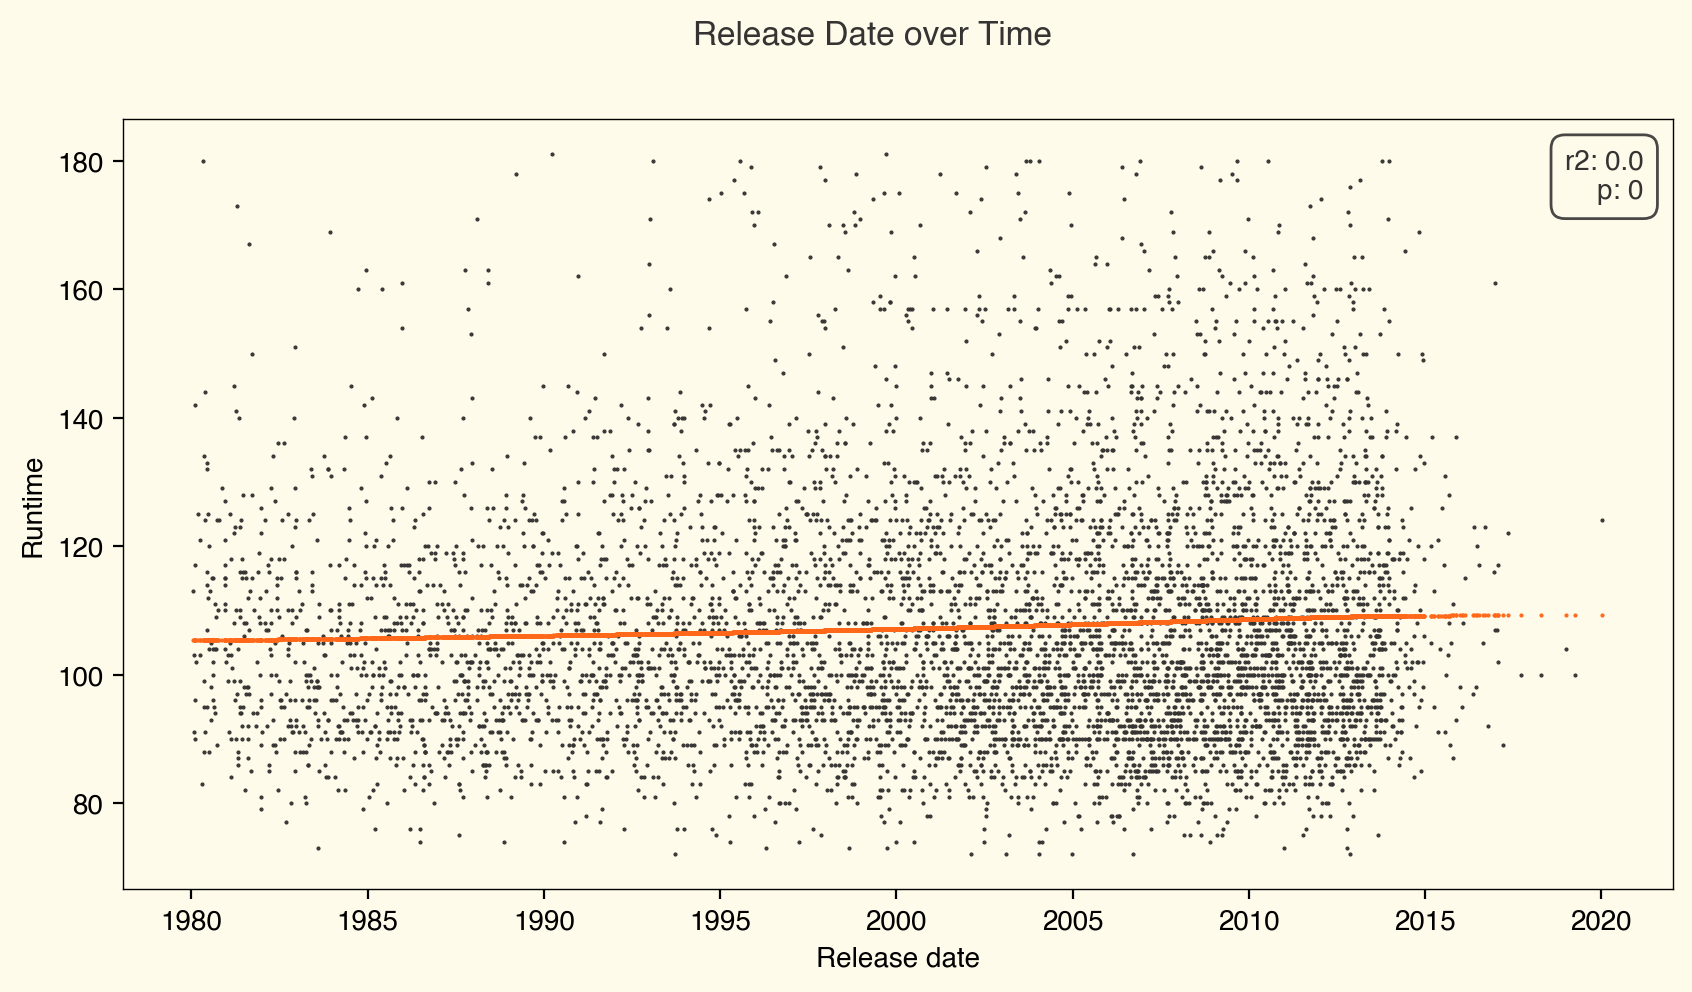

In [35]:
fig, ax = plt.subplots(figsize=(10,5))

df['release_date'] = md.to_datetime(df['release_date'])
df.sort_values(by='release_date', inplace=True, ascending=True)

plotDf = df[df['release_date'] > datetime(1980,1,1)]

xVar = 'release_date'
yVar = 'runtime'

model = linearModelGeneral(X = np.arange(len(plotDf)), y = np.array(plotDf[yVar]), degrees = [1,2])


ax.scatter(plotDf[xVar], plotDf[yVar], marker='.',s=1)
ax.scatter(plotDf[xVar], model['ypred'], marker='.',s=1, c=colorPalette['annotation'])

annotation_text = f"r2: {round(model['r2'], 2)}\np: {round(model['p'])}"
ax.annotate(annotation_text, xy=(.99, .98), xycoords='axes fraction', fontsize=10,
        xytext=(-5, -5), textcoords='offset points',
        ha='right', va='top',
        bbox=dict(boxstyle='round,pad=0.5', edgecolor=colorPalette['grey_light'], facecolor=colorPalette['canvas']))

ax.set_xlabel(titleify(xVar).replace('_', ' '))
ax.set_ylabel(titleify(yVar))

# Set title
fig.suptitle('Release Date over Time', fontsize=12)

imageFilePath = os.path.join(saveImagePath, 'releaseDateRuntime.png')
plt.savefig(imageFilePath, dpi=300)

# Show the figure
plt.show()

In [29]:
model['p']

0.004661674905697248